In [30]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
torch.__version__

'1.10.1+cpu'

In [31]:
df = pd.read_csv('reviews.csv')


In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from pymystem3 import Mystem
from string import punctuation
from nltk.stem.snowball import SnowballStemmer 
#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")


stemmer = SnowballStemmer("russian") 
#Preprocess function
def preprocess_text(text):
    text = (lambda f: re.sub(r'\d|\W', ' ', text))(text)
    tokens = mystem.lemmatize(text.lower())
    #tokens = text.lower().split(' ')
    #tokens = [stemmer.stem(word) for word in text.lower().split(' ')]
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation\
              and len(token) > 3]
    text = " ".join(tokens)
    
    return text


df['review'] = [(lambda f: preprocess_text(text))(text) for text in df['review']]

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df["status"])
df['status'] = le.transform(df['status'])

In [55]:
df.head()

,id,status,review,usefull,useless
0,/film/326/,1,побег шоушенка экранизация роман стивен кинг в...,762,62
1,/film/326/,1,представлять обычный законопослушный гражданин...,220,35
2,/film/326/,1,случаться америка назад хотеть соприкасаться п...,217,38
3,/film/326/,1,некоторые птица неволя удерживать перо слишком...,117,28
4,/film/326/,1,сегодня смотреть шедевр мировой кино наверное ...,102,24


In [56]:
x_train, x_test, y_train, y_test = train_test_split(
    df['review'], df['status'], test_size=.2, stratify=df['status'], random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2857,) (715,) (2857,) (715,)


In [57]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [58]:
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(x_train)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(x_test)).float()

In [59]:
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [73]:
model = nn.Sequential(nn.Linear(300, 64),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(64, df['status'].nunique()),
                      nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()

logps = model(x_train)
y_train = y_train.type(torch.LongTensor)

# Calculate the loss with the logits and the labels
loss = criterion(logps, y_train)

loss.backward()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.002)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2857x34473 and 300x64)

In [64]:
y_test = y_test.type(torch.LongTensor)


In [65]:
%%time
train_losses = []
test_losses = []
test_accuracies = []

epochs = 50
for e in range(epochs):
    optimizer.zero_grad()

    output = model.forward(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    optimizer.step()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        log_ps = model(x_test)
        test_loss = criterion(log_ps, y_test)
        test_losses.append(test_loss)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y_test.view(*top_class.shape)
        test_accuracy = torch.mean(equals.float())
        test_accuracies.append(test_accuracy)

    model.train()

    print(f"Epoch: {e+1}/{epochs}.. ",
          f"Training Loss: {train_loss:.3f}.. ",
          f"Test Loss: {test_loss:.3f}.. ",
          f"Test Accuracy: {test_accuracy:.3f}")

Epoch: 1/50..  Training Loss: 1.105..  Test Loss: 1.100..  Test Accuracy: 0.313
Epoch: 2/50..  Training Loss: 1.097..  Test Loss: 1.095..  Test Accuracy: 0.313
Epoch: 3/50..  Training Loss: 1.088..  Test Loss: 1.089..  Test Accuracy: 0.410
Epoch: 4/50..  Training Loss: 1.076..  Test Loss: 1.082..  Test Accuracy: 0.484
Epoch: 5/50..  Training Loss: 1.063..  Test Loss: 1.076..  Test Accuracy: 0.478
Epoch: 6/50..  Training Loss: 1.049..  Test Loss: 1.070..  Test Accuracy: 0.464
Epoch: 7/50..  Training Loss: 1.034..  Test Loss: 1.062..  Test Accuracy: 0.462
Epoch: 8/50..  Training Loss: 1.017..  Test Loss: 1.055..  Test Accuracy: 0.459
Epoch: 9/50..  Training Loss: 0.999..  Test Loss: 1.047..  Test Accuracy: 0.463
Epoch: 10/50..  Training Loss: 0.981..  Test Loss: 1.040..  Test Accuracy: 0.464
Epoch: 11/50..  Training Loss: 0.963..  Test Loss: 1.033..  Test Accuracy: 0.470
Epoch: 12/50..  Training Loss: 0.944..  Test Loss: 1.025..  Test Accuracy: 0.476
Epoch: 13/50..  Training Loss: 0.923.

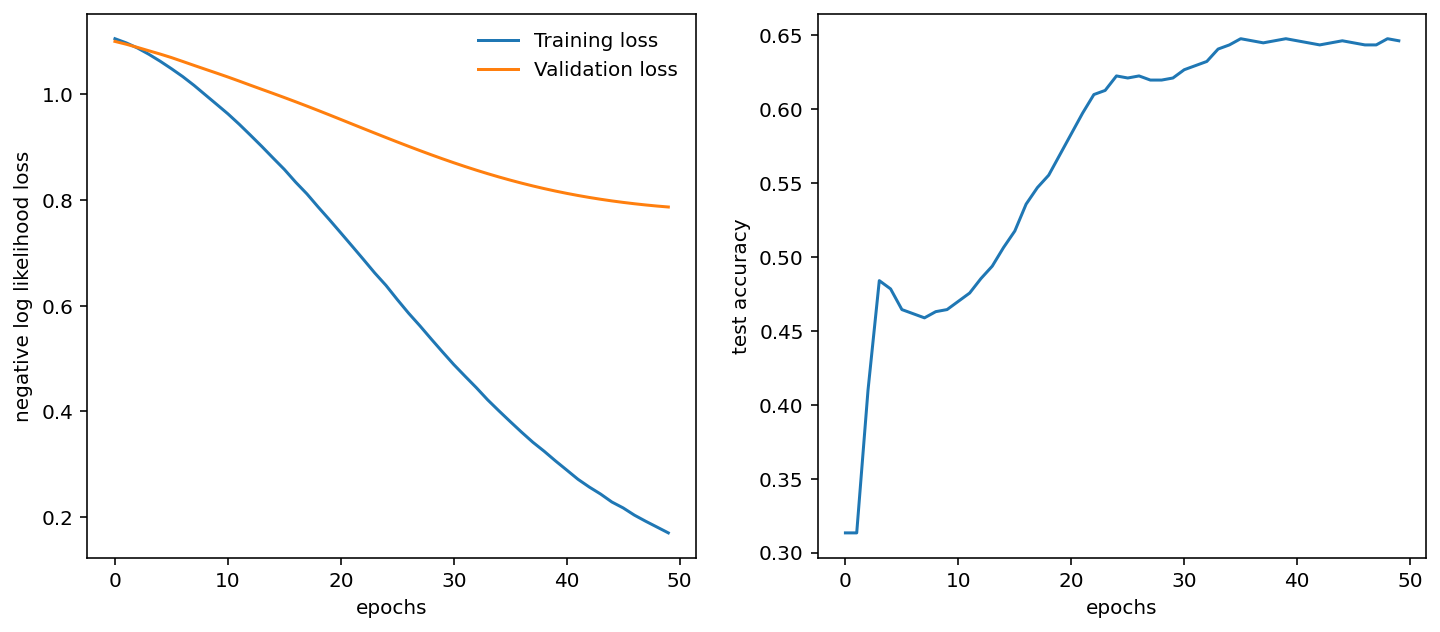

In [66]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('negative log likelihood loss')
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False);
plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(test_accuracies)

In [67]:
torch.save(model.state_dict(), 'model.pt')

In [70]:
df["status"].nunique()

3

In [72]:
x_train.shape[1]

34473